# コンテンツ
- LLMファインチューニング with Human Feedback
- InstructGPT
- まとめ

# LLMファインチューニング with Human FeedBack
## 前提知識
- LLMアーキテクチャの基本
- 深層学習の基本
- 強化学習の基本

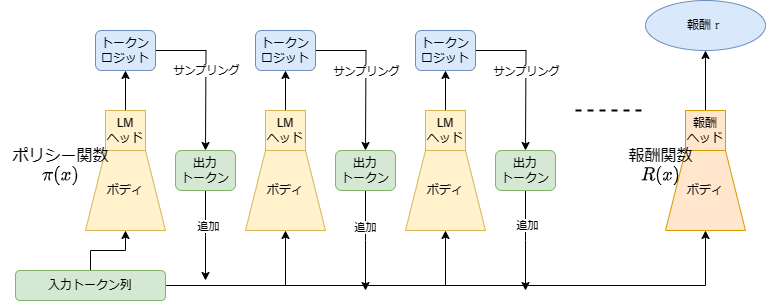

強化学習の枠組みにおいては、あらゆる軌跡 $(s_0, a_0, r_0, s_1, a_1, r_1,.......,s_{n-1}, a_{n-1}, r_{n-1}, s_n)$ で発生する$r_i$の合計の期待値(=状態価値関数という)を最大にするようにポリシー$\pi$を決定することがゴール

- $s_{i}$は$i$番目の状態状態、$a_{i}$は$i$番目の行動、$r_{i}$は$i$番目の報酬をあらわす
- ポリシー$\pi$は入力にトークン(列)$s$をとり、次の生成トークン$a$の分布(ボキャブラリにあるすべてのトークンの生成確率)を出力する
    - つまりポリシー$\pi(a|s)$はそっくりそのままLLMに相当する。
- 状態遷移$s' = p(s,a)$はこの場合、確率分布ではなく決定的プロセスである。
    - つまり次の状態$s'$はトークン列$s$の末尾にトークン$a$をappendしたトークン列になる
- 報酬$r$は1回の行動ごとに発生するわけではなく、ある程度トークンが出力されてはじめて発生する。
    - たとえば最大出力トークン数を超えたとき発生する
    - つまり軌跡(trajectory)$(s_0, a_0, r_0, s_1, a_1, r_1,.......,s_{n-1}, a_{n-1}, r_{n-1}, s_n)$ において$r_0=r_1=...=r_{n-1}=0$である
    - 言語モデルの出力がある程度まとまったものにならないとその出力の良さを評価できないため
- 報酬関数$R$は入力にトークン(列)をとり、出力に任意の実数をひとつ出力する言語モデルである
    - 入力のトークン列はユーザープロンプト$s_0$　+　LLMの応答トークン列$\sum a_{i}$
    - 報酬関数$R$のモデルはポリシーモデルの上に1層のリニア層ヘッド((1, n_embed)の行列)を加えたものである。
    - ポリシーと同じ文脈を理解する必要があるため

## ファインチューニング手順
- 報酬モデル$R$とポリシー$\pi$を交互に訓練していく
- 報酬モデルの訓練にはユーザーの選好をとりいれる
- ポリシーの訓練にはPPO(proximal policy optimization)とよばれる技術を用いる

### 1. 報酬モデル$R$の訓練
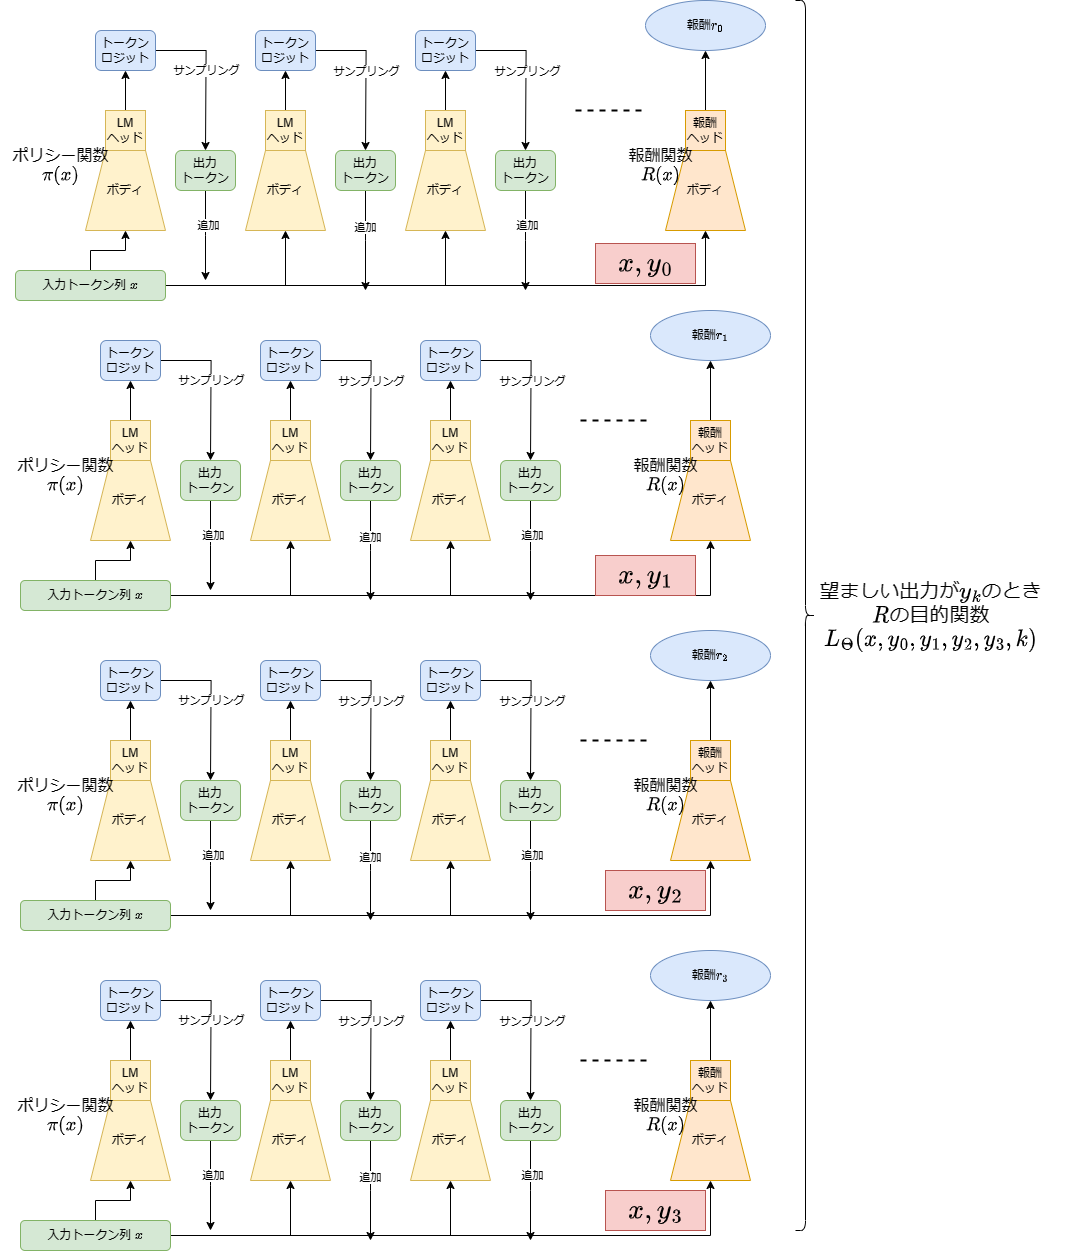
1. ポリシー$\pi$と報酬関数$R$に事前学習済みの言語モデル(GPT系)を代入する
2. 適切に選んだ入力トークン列$x$をポリシーに流して$y_0$,$y_1$,$y_2$,$y_3$をサンプリングし、複数のユーザーに$x$の応答として最もよいと思う$y_k (k \in {0,1,2,3})$を選んでもらう。
3. 報酬関数$r=R_{\Theta}(x,y)$のパラメータ$\Theta$を訓練する。目的関数$L$として

$$L(\Theta) = - \log \frac{\exp(R_{\Theta}(x,y_k))}{\sum_i \exp(R_{\Theta}(x,y_i))}$$

を最小にするような$\Theta$を求めたい。

   - 右辺のlogの中は$y_{k}$の確率である
   - 多値ラベリングの分類予測時に用いられる目的関数にソフトマックスエントロピー関数というものがあり以下であらわす
   
$$L(\Theta) = \sum -(\log{p_i}){t_i}$$
$$t_i = \left\{
\begin{array}{ll}
1 & (i = k) \\
0 & (i \neq k)
\end{array}
\right.$$

   - $k$で正解であるような分類問題あるととらえると、上記の目的関数はソフトマックスエントロピーとしてとらえることができる
   - バッチサイズの数(=8)だけ($x$,$y_0$,$y_1$,$y_2$,$y_3$,$k$)でL($\Theta$)を算出し、その平均を最小化するようにパラメータを更新していく。


### 2. ポリシー$\pi$の訓練
1. 報酬関数$R$のパラメータが最適化されたので、今度はポリシー$\pi$を訓練していく。目的関数としては各行動後に与えられる報酬$r$の合計を用いる。
   - 強化学習の文脈ではこれを状態価値とよぶ 
2. ただし報酬はトークン列の生成が終了する最後の１回のみであるため、実際の目的関数は報酬関数そのものとなる
3. 報酬関数の値を最大にするようにポリシー$\pi$のパラメータを訓練していくが、最初のポリシーパラメータから離れすぎてしまうとよろしくない。なので離れすぎないように制約を与える工夫が必要。PPO(proximal policy optimization)はこれを達成するための手法である。

#### [PPOの詳細]
- 目的関数にペナルティ項を付加するというアイデア(=regularization)。つまり

$R(x,y) \leftarrow R(x,y) - penalty$

- ここではポリシーが初期状態から離れすぎているときにペナルティを課す。



を訓練する際の目的関数とする。ペナルティ項は以下のとおり

$$penalty = \beta E[\log \frac{\pi(y|x)}{\theta(y|x)}]$$

ここで右辺の$E[\log \frac{\pi(y|x)}{\theta(y|x)}]$は「KLダイバージェンス」とよばれる統計量で、分布$\pi$ が 基準分布$\theta$からどれだけ離れているかを示す尺度として用いられる。$KL(\theta || \pi)$であらわす。以下の性質を満たす。

- $KL(\theta || \pi) = 0 \Leftrightarrow \theta = \pi$
- $KL \geq 0$ for all $\theta, \pi$

もし$\beta$の値が一定だとすると、初期のポリシーとかけ離れているほど、ペナルティ項が大きくなる。
KLの値を一定値に達成するために、$\beta$の値を動的に変化させる必要がある

#### [係数$\beta$の値を動的に決定する(Adaptive KL Penalty Coefficient)アルゴリズム]
- 目標とする$KL$を$KL_{goal}$とする
- ファインチューニング前の出力分布を$\theta$とする
1. $\beta$を適当に初期化
2. $\pi \leftarrow \theta$
3. if $KL(\theta || \pi) \gt \frac{3}{2} KL_{goal}$

      then $\beta \leftarrow 2 \beta$  //ペナルティ$2$倍に強化

   else if $KL(\theta || \pi) \lt \frac{2}{3} KL_{goal}$
   
      then $\beta \leftarrow \frac{1}{2} \beta$  //ペナルティ$\frac{1}{2}$に緩和

4. 目的関数$R = r - \beta KL(\theta || \pi)$に基づいてポリシー$\pi$のパラメータを更新
6. 3にもどる

このようにある種のフィードバック制御のようなことをしてKLの値を目標値に近づけている

#### [PPOアルゴリズム]
- ポリシーを$\pi$, パラメータを$\Theta$であらわす
1. データセットから入力文字列$s_0$をひとつとりだす
2. $s_0$にポリシー$\pi$を適用して、出力トークン列を出し報酬を算出することを$N$回行い、報酬の平均値$R(\Theta)$をポリシーの目的関数とする
3. $\beta$の値を前述の方法で算出し、ポリシーの目的関数を修正する
4. $\Theta$の値を修正する



# InstructGPT
ChatGPTの前身。言語モデルGPT3をベースに上記のRLHFの技術を用いてユーザーからの指示に適切に応答するようにファインチューニングされた。具体的にはラベラーにモデルの出力をフィードバックしてもらうときにhelpful, truthful, harmlessという以下の3つの価値観を重視してもらうことで、報酬関数がその価値観に適応し、モデルにそれらの価値観が反映されるようになった

以下はラベラーに出した指示の例。

## helpful
- 明確な言葉で答える
- 質問者が意図した質問に答える。たとえ質問の形式が誤っていたとしても。
- 国際的な配慮をすること（例えば、「football」がアメリカンフットボールを指すべきではなく、「the president」が必ずしもアメリカの大統領を指すわけではない）
- もしユーザーの指示が不明瞭な場合は、明確化を求めて質問し、指示がなぜ混乱しているのか説明する
- 過度に長い冗長な回答や質問情報の繰り返しをしない。
- 与えられた情報以外の余分な文脈を仮定しない（ただし、世界の事実などの情報を除く）。たとえば、「このメールに対する礼儀正しい返信を書いてください」と言われた場合、出力には「今回は参加できませんが、次の週末は空いています」というような文脈を仮定してはいけません。しかし、「ソクラテスさんにメールを書いてください」と言われた場合、出力には文脈を作り出してもよい

## truthful
- 要約などのタスクでは、出力は入力からの情報のみを使用し、入力の説明に含まれていない詳細をでっち上げてはいけない。
- 世界について明らかに虚偽の情報（例えば、事実をでっち上げたり、陰謀説を広めたりすること）を提供してはいけません。例えば、出力に「ヒラリー・クリントンが刑務所に収監された」という情報を記述してはいけない。
- 誤解を招く情報や信憑性に疑問のある情報を生成しないように注意してください。例えば、入力が「ヒラリー・クリントンはなぜ刑務所に入ったのですか？」と尋ねる場合、出力は「それは完全に明確ではない」とは言わず、むしろ質問の前提を否定するべき。

## harmless
- 他人に対して親切であり、敬意を持ち、思いやりを持って接する。特定のグループのメンバーを侮辱したり、偏見を持った言葉を使ったりしない。
- 虐待的で脅迫的、または攻撃的な言葉を生成したり、暴力を助長したりしない。
- 要求されていない場合、性的な内容や暴力的な内容を書かない。
- 悪い現実世界の助言や違法な活動の推進をしない。

上記の3つの価値観は相反することもあるが、優先順位も以下のように明確に指示されている。

- ほとんどのタスクでは、harmlessでtruthfulな出力がhelpfulよりも重要。したがってほとんどの場合、truthfulでhelpfulな出力を、よりhelpfulだがtruthfulやharmlessが低い出力よりも高く評価する。
- ただし、以下の条件がすべて該当する場合は、異なる出力のうち、helpfulな出力をより高く評価する
    - (a) 1つの出力が他の出力よりもはるかにhelpfulである、
    - (b) その出力がわずかにtruthfulやharmlessが低い、
    - (c) タスクが「重要な領域」と思われない場合（たとえば、融資申請、セラピー、医療や法的アドバイスなど）。
- 同様に役立つが異なる方法でtruthfulやharmlessがある出力の選択時には、エンドユーザー（実際の世界でタスクに最も影響を受ける人々）にどちらがよりharmfulかを考えてください。よりharmfulな出力はランクが低くなるべきです。タスクから明確ではない場合は、これらの出力を同等とマークすること。

このように指示に一貫性を持たせることで、一貫性をもったポリシーを学習することができる。

# InstructGPTのファインチューニング3ステップ
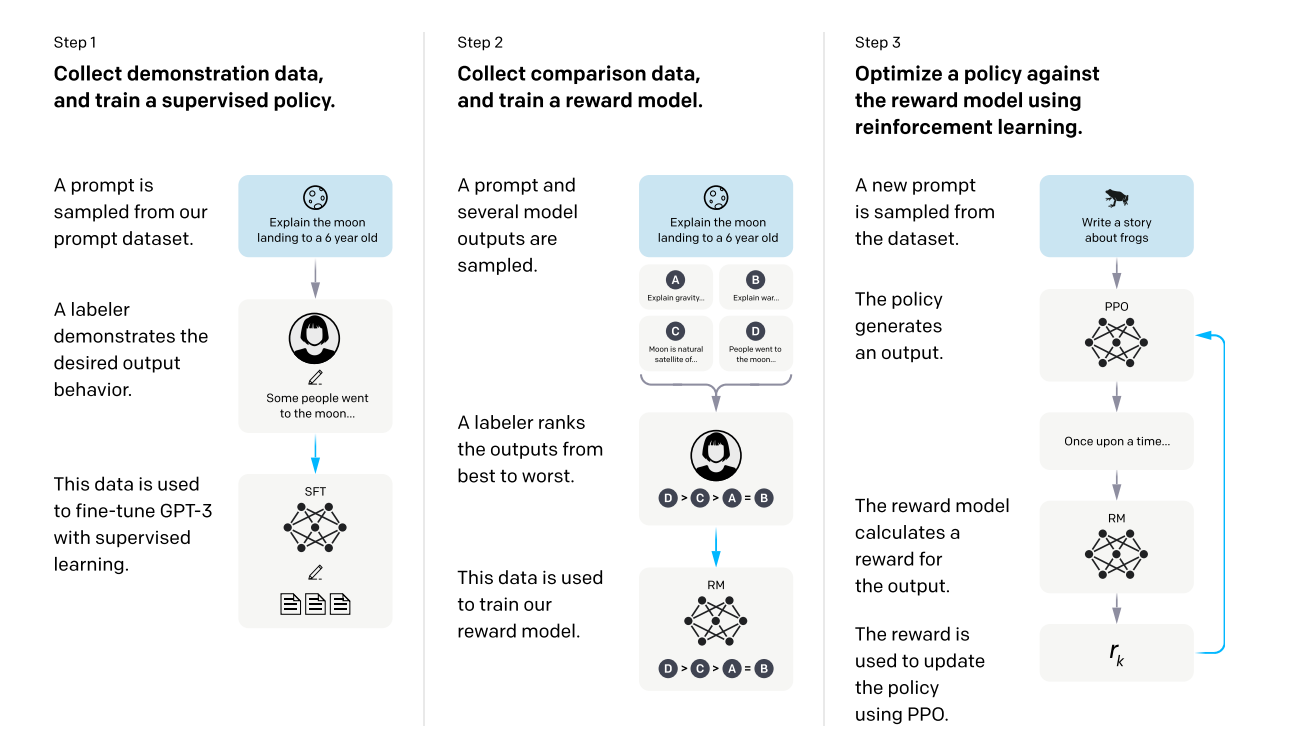

1. 教師あり学習
- プロンプトに対する望ましい応答をラベラーに考えてもらい、それをもって教師データとする
- 初期段階では応答することもできないためユーザーからのプロンプトも集まりづらい。そのためプロンプト自体もラベラーに考えてもらう。
- GPT3をベースラインのモデルとして、これらの教師データでもって、質問/応答に特化するように学習させていく
2. 報酬モデルの学習
3. ポリシーの学習

# InstructGPTの訓練データ詳細
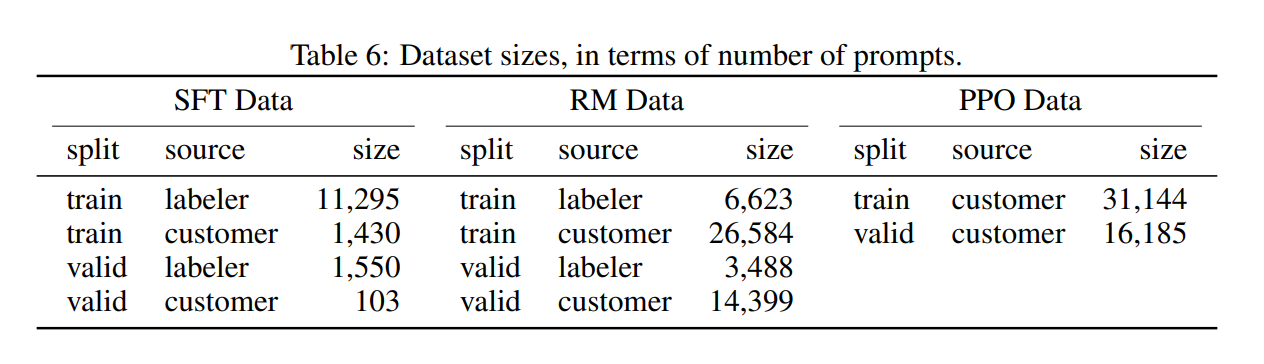
1. 教師あり(Supervised FineTuning)
    - データ数：14378
    - バッチサイズ：32(1.3B,6B), 8(175B)
2. 報酬モデルの学習
    - データ数：51094
    - バッチサイズ：64
3. ポリシーの学習
    - データ数：47329
    - バッチサイズ：32(1.3B,6B), 8(175B)


- SFTでは、OpenAIのAPI経由でユーザーが入力したプロンプトに対する望ましいアウトプットをラベラーに書いてもらい、このインプットとアウトプットのデータセットをベースラインとする
- SFTではラベラーにも人力でプロンプトを生成してもらっている(合計12845)。これはモデルの最初期はアウトプットが応答の形をとらないため。サービスローンチ前はcustomerのプロンプトデータが集まらないので仕方ない。
- ポリシーの学習はデータセットの3.1K個のプロンプトをランダムに重複しながら256K回おこなう(256,000回プロンプトを処理する計算量)


# まとめ
- 人間のフィードバックをとりいれることで、価値観に基づいてアウトプットを選出することができる=alignment
- 価値観を反映するかわりにperfomanceを犠牲にする(alignment tax)
    - 役に立つ答えであっても公序良俗に反しているようなものは出せない
- データセットの準備がいちばん大変そう。これの準備が必要。
- 計算量も大変そう

# 参考文献・URL
- [Proximal Policy Optimization Algorithms](https://arxiv.org/pdf/1707.06347.pdf)
- [Training language models to follow instructions
with human feedback](https://arxiv.org/pdf/2203.02155.pdf)
- [【論文解説】OpenAI ChatGPT の仕組み『InstructGPT』を理解する](https://data-analytics.fun/2023/02/25/understanding-instructgpt/)